#Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Check for cuda installed version

In [ ]:
!/usr/local/cuda/bin/nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


#Download the appropriate cuDNN files and Unzip the cuDNN files from Drive folder directly to the VM CUDA folders(needs to be done only once)


In [ ]:
!tar -xzvf gdrive/My\ Drive/Fire_detection/cuDNN/cudnn-10.1-linux-x64-v7.6.5.32.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h



cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.6.5
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


# Check for proper installation. Can be commented out on future runs


In [ ]:
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

# Clone Darknet

In [ ]:
!git clone https://github.com/kriyeng/darknet/

!ls

!git checkout feature/google-colab



Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068
Receiving objects: 100% (10068/10068), 10.15 MiB | 5.86 MiB/s, done.
Resolving deltas: 100% (6735/6735), done.
darknet  gdrive  sample_data
fatal: not a git repository (or any of the parent directories): .git


#We need to make a few changes in the Makefile code in order to make use of gpu for processing.

In [ ]:
%cd /content/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


#Compile Darknet


In [ ]:
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(mat_cv*, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:896:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘bool JSON_sende

# YOLO weights file download(optional)

In [ ]:
#!wget https://pjreddie.com/media/files/yolov3.weights

--2020-07-11 06:18:13--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  7.63MB/s    in 41s     

2020-07-11 06:18:54 (5.82 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



# Copy yolov3 weights from drive to VM Folder(optional, just for checking darknet installation)

In [ ]:
!cp /content/gdrive/My\ Drive/Fire_detection/darknet/yolov3.weights /content/darknet


#Some useful Functions

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
      
def download(path):
  from google.colab import files
  files.download(path)

#Test Darknet Installation(Optional)

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

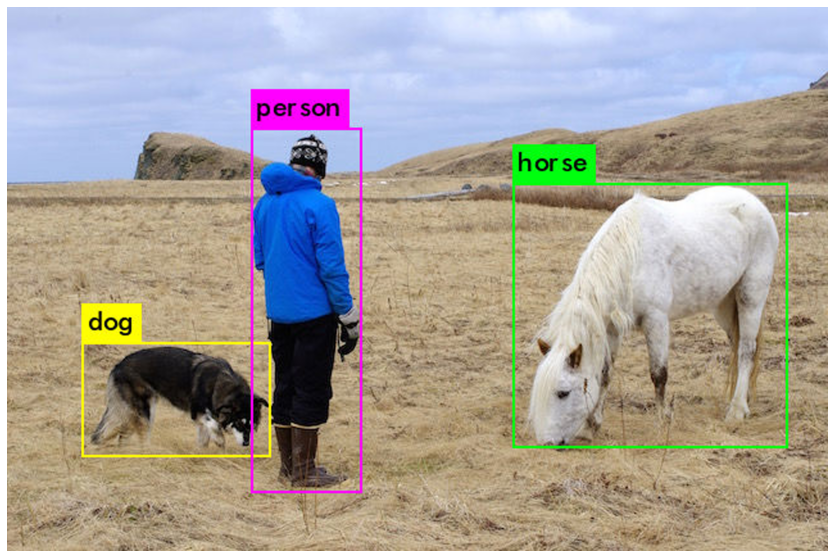

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg -dont-show
imShow('predictions.jpg')

In [ ]:
%cd /content

/content


#Install Dos2Unix

In [ ]:
!sudo apt install dos2unix

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  dos2unix
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 351 kB of archives.
After this operation, 1,267 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 dos2unix amd64 7.3.4-3 [351 kB]
Fetched 351 kB in 2s (190 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconf

#Convert the Windows generated files into UNIX format(If you are using linux this step can be skipped)

In [ ]:
!dos2unix /content/gdrive/My\ Drive/Fire_detection/custom/train.txt
!dos2unix /content/gdrive/My\ Drive/Fire_detection/custom/test.txt
!dos2unix /content/gdrive/My\ Drive/Fire_detection/custom/trainer.data
!dos2unix /content/gdrive/My\ Drive/Fire_detection/custom/classes.names
!dos2unix /content/gdrive/My\ Drive/Fire_detection/custom/yolov3-custom.cfg

dos2unix: converting file /content/gdrive/My Drive/Fire_detection/custom/train.txt to Unix format...
dos2unix: converting file /content/gdrive/My Drive/Fire_detection/custom/test.txt to Unix format...
dos2unix: converting file /content/gdrive/My Drive/Fire_detection/custom/trainer.data to Unix format...
dos2unix: converting file /content/gdrive/My Drive/Fire_detection/custom/classes.names to Unix format...
dos2unix: converting file /content/gdrive/My Drive/Fire_detection/custom/yolov3-custom.cfg to Unix format...


# Copy the required files from Drive to VM /content/darknet folder 

In [ ]:
!cp /content/gdrive/My\ Drive/Fire_detection/custom/classes.names /content/darknet
!cp /content/gdrive/My\ Drive/Fire_detection/custom/darknet53.conv.74 /content/darknet
!cp /content/gdrive/My\ Drive/Fire_detection/custom/test.txt /content/darknet
!cp /content/gdrive/My\ Drive/Fire_detection/custom/train.txt /content/darknet
!cp /content/gdrive/My\ Drive/Fire_detection/custom/trainer.data /content/darknet
!cp /content/gdrive/My\ Drive/Fire_detection/custom/yolov3-custom.cfg /content/darknet

In [ ]:
%cd darknet

/content/darknet


# Copy the dataset images and corresponding annotation files from Drive to VM(This makes the training process a bit faster)

In [ ]:
!mkdir dataset
!cp /content/gdrive/My\ Drive/Fire_detection/FD_dataset/*.jpg /content/darknet/dataset
!cp /content/gdrive/My\ Drive/Fire_detection/FD_dataset/*.txt /content/darknet/dataset
!mkdir dataset2
!cp /content/gdrive/My\ Drive/Fire_detection/FD_dataset2/*.jpg /content/darknet/dataset2
!cp /content/gdrive/My\ Drive/Fire_detection/FD_dataset2/*.txt /content/darknet/dataset2



# Begin Training. The code saves the generated .weights files for every 1000 iterations(Can be modified according to choice)

In [ ]:
!./darknet detector train "/content/darknet/trainer.data" "/content/darknet/yolov3-custom.cfg" "/content/darknet/backup/yolov3-custom_10000.weights" -dont_show

Streaming output truncated to the last 5000 lines.
Region 16 Avg IOU: 0.773576, Class: 0.999176, Obj: 0.601924, No Obj: 0.001223, .5R: 1.000000, .75R: 0.600000,  count: 10
Region 23 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 16 Avg IOU: 0.765654, Class: 0.999219, Obj: 0.366707, No Obj: 0.001285, .5R: 1.000000, .75R: 0.500000,  count: 14
Region 23 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 16 Avg IOU: 0.731165, Class: 0.999031, Obj: 0.356828, No Obj: 0.001371, .5R: 1.000000, .75R: 0.411765,  count: 17
Region 23 Avg IOU: 0.594915, Class: 0.999680, Obj: 0.107005, No Obj: 0.000020, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 16 Avg IOU: 0.683910, Class: 0.999491, Obj: 0.198801, No Obj: 0.001036, .5R: 0.923077, .75R: 0.230769,  count: 13
Region 23 Avg IOU: 0.792068, Class: 0.999942, Obj: 0.852499, No Obj: 0.000025, .5R: 1.000000, .75R: 1.000000,  count: 1

 11797: 1.317677, 1.0343

#Test on sample image for detection

layer     filters    size              input                output
   0 conv     16  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  16 0.319 BF
   1 max          2 x 2 / 2   608 x 608 x  16   ->   304 x 304 x  16 0.006 BF
   2 conv     32  3 x 3 / 1   304 x 304 x  16   ->   304 x 304 x  32 0.852 BF
   3 max          2 x 2 / 2   304 x 304 x  32   ->   152 x 152 x  32 0.003 BF
   4 conv     64  3 x 3 / 1   152 x 152 x  32   ->   152 x 152 x  64 0.852 BF
   5 max          2 x 2 / 2   152 x 152 x  64   ->    76 x  76 x  64 0.001 BF
   6 conv    128  3 x 3 / 1    76 x  76 x  64   ->    76 x  76 x 128 0.852 BF
   7 max          2 x 2 / 2    76 x  76 x 128   ->    38 x  38 x 128 0.001 BF
   8 conv    256  3 x 3 / 1    38 x  38 x 128   ->    38 x  38 x 256 0.852 BF
   9 max          2 x 2 / 2    38 x  38 x 256   ->    19 x  19 x 256 0.000 BF
  10 conv    512  3 x 3 / 1    19 x  19 x 256   ->    19 x  19 x 512 0.852 BF
  11 max          2 x 2 / 1    19 x  19 x 512   ->    19 x  19 x 512 0.001 

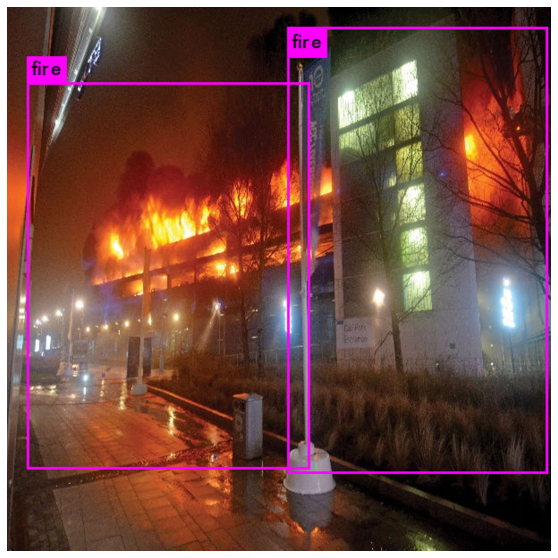

In [ ]:
!./darknet detector test trainer.data yolov3-custom.cfg backup/yolov3-custom_10000.weights dataset/1008.jpg 
imShow('predictions.jpg')

#Copy weights file to Drive for future use

In [ ]:
!cp /content/darknet/backup/yolov3-custom_12000.weights /content/gdrive/My\ Drive/Fire_detection/